Telecom Churn Prediction Model

In [5]:
!pip install scikit-learn==1.5.2
!pip install pandas scikit-learn xgboost imbalanced-learn matplotlib seaborn
!pip install -r requirements.txt -q

In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## 1. Load the data and Explore the data

This section focuses on loading the telecom customer churn dataset and gaining an initial understanding of its structure and characteristics.

### Data Overview
- **Number of Samples** 2666
- **Number of Features** 20
- **Target Variable** 'Churn' (True/False indicating churn)


In [7]:
df = pd.read_csv('/content/churn-bigml-80.csv')

## 2. Data Preprocessing

This phase prepares the data for model training. It includes handling missing values, encoding categorical features, scaling numerical features, and addressing class imbalance.

### 2.1. Dropping Irrelevant Columns
The `Phone` column acts as a unique identifier for each customer and does not contribute directly to churn prediction. Therefore, it is removed from the dataset.

In [8]:
# delete the phone column
# This column is not needed for our prediction model

if "Phone" in df.columns:
    df.drop("Phone", axis=1, inplace=True)
    print("Phone column deleted successfully.")
else:
    print("Phone column not found in the DataFrame.")


# Transform the "Churn" column True/False to 1/0 (Target Variable)

df['Churn'] = df['Churn'].astype(int)

Phone column not found in the DataFrame.


### 2.2. One-Hot Encoding for Categorical Features
Categorical features like `State`, `Area code`, `International plan`, and `Voice mail plan` cannot be directly processed by most machine learning models. They are transformed into numerical features using One-Hot Encoding. The `drop_first=True` option is used to avoid multicollinearity and reduce the number of generated columns.

In [9]:
# One-hot-incoding

categorical_columns = ['State', 'Area code', 'International plan', 'Voice mail plan']

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

### 2.3. Numerical Feature Scaling
Numerical features often have different scales (e.g., `Total day minutes` vs. `Customer service calls`). Using `StandardScaler`, these features are standardized to have a mean of 0 and a standard deviation of 1. This prevents features with larger numerical ranges from disproportionately influencing the model.

In [10]:
# Selecting Numeric Columns

numeric_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' in numeric_columns:
    numeric_columns.remove('Churn') # Excluding the Target


# StadardScaler

scaler = StandardScaler()

df_scaled = df_encoded.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df_encoded[numeric_columns])

### 2.4. Handling Class Imbalance (SMOTE)
The `Churn` class (customers who churned) represents a minority class, constituting approximately 14.6% of the dataset. To prevent the model from being biased towards the majority class (non-churners), `SMOTE` (Synthetic Minority Over-sampling Technique) is applied to the training data. This technique generates synthetic samples for the minority class, balancing the dataset for more effective model learning.

In [11]:
from re import X
x = df_scaled.drop('Churn', axis=1)
y = df_scaled['Churn']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("Ratio of Churn in the original data train set")
print(y_train.value_counts(normalize=True))


# SMOTE (Oversampling the data)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Ratio of Churn in the resampled data train set")
print(y_resampled.value_counts(normalize=True))



Ratio of Churn in the original data train set
Churn
0    0.854597
1    0.145403
Name: proportion, dtype: float64
Ratio of Churn in the resampled data train set
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


## 3. Model Training (XGBoost)

We employ the powerful `XGBoost` classifier for predicting customer churn. XGBoost is an ensemble learning method that sequentially builds multiple weak decision trees, with each new tree correcting the errors of the preceding ones.

In [12]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)



GridSearchCV Train Start...
Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV Train Finish...


### 3.1. Hyperparameter Tuning with GridSearchCV
To optimize the model's performance, `GridSearchCV` is used to systematically search for the best combination of `XGBoost` hyperparameters, such as `n_estimators`, `learning_rate`, and `max_depth`. The `ROC-AUC` score, which is robust for imbalanced datasets, is used as the primary metric for selecting the best model.

In [ ]:
# Grid Search

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring = 'roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Train GridSearchCV

print("GridSearchCV Train Start...")
grid_search.fit(X_resampled, y_resampled)
print("GridSearchCV Train Finish...")


## 4. Model Evaluation and Interpretation
This section evaluates the model's performance on unseen data and analyzes which features have the most significant impact on customer churn.

In [13]:
# Choose the best model

best_model = grid_search.best_estimator_
print("="*50)

# Best Parameter

print("\nBest Parameter")
print(grid_search.best_params_)

# Best Score

print("\nBest Score")
print(grid_search.best_score_)
print("="*50)




print("\nXGBoost Model Train Start...")
model.fit(X_resampled, y_resampled)
print("XGBoost Model Train Finish...")

# Prediction for the test set

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print("\nModel Prediction (%)")
print(y_pred_proba[:10])
print("\nModel Prediction (Class)")
print(y_pred[:10])


Best Parameter
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

Best Score
0.994499552664886

XGBoost Model Train Start...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:06:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Train Finish...

Model Prediction (%)
[0.00496443 0.04394048 0.00131709 0.00306608 0.00087725 0.00747422
 0.0070281  0.01279601 0.01540419 0.00229032]

Model Prediction (Class)
[0 0 0 0 0 0 0 0 0 0]


### 4.1 Feature Importance Analysis
We analyze the `feature_importances` attribute of the `XGBoost` model to understand the relative contribution of each feature to churn prediction. This analysis helps in understanding the underlying causes of churn from a business perspective, informing targeted retention strategies.


 Top10 Feature Importance
                   Feature  Importance
67  International plan_Yes    0.148349
14  Customer service calls    0.058425
2        Total day minutes    0.048906
7         Total eve charge    0.042591
40                State_MT    0.038839
1    Number vmail messages    0.038816
57                State_TX    0.037385
49                State_OH    0.036405
21                State_DC    0.033735
24                State_GA    0.033097


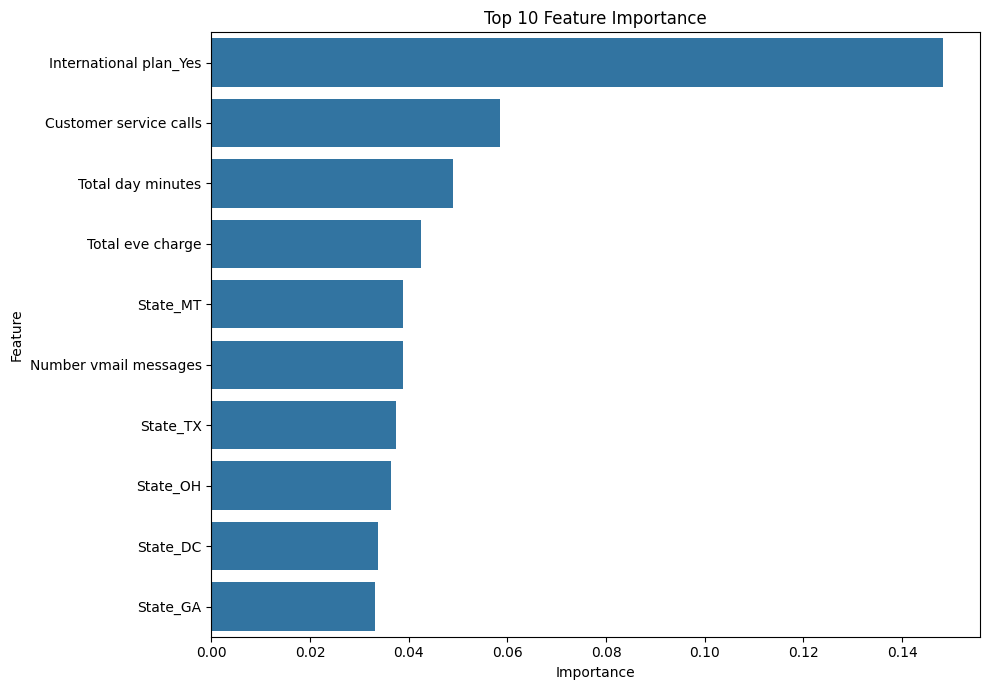

In [14]:
# Feature Importance

feature_importance = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    f"Feature": feature_names,
    f"Importance": feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# top 10 importances

print("\n Top10 Feature Importance")
print(importance_df.head(10))

# Visualize the importances

plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### 4.2 Performance Metrics
Considering the imbalanced nature of the dataset, we use a comprehensive set of evaluation metrics beyond simple accuracy:

- **Accuracy**: Overall correctness of predictions.

- **Precision**: The proportion of correctly predicted positive observations out of all positive predictions.

- **Recall** (Sensitivity): The proportion of correctly predicted positive observations out of all actual positive observations. (Crucial for churn prediction, as missing actual churners can be costly.)

- **F1-Score**: The harmonic mean of Precision and Recall, providing a balance between the two.

- **ROC-AUC**: Measures the model's ability to distinguish between churners and non-churners across various threshold settings.

- **Confusion Matrix**: Provides a detailed breakdown of correct and incorrect predictions (True Positives, True Negatives, False Positives, False Negatives).


Model Performance
Accuracy:, 0.9438
Precision:, 0.9000
Recall:, 0.6923
F1 Score:, 0.7826
ROC-AUC:, 0.8541
Confusion Matrix:
[[450   6]
 [ 24  54]]


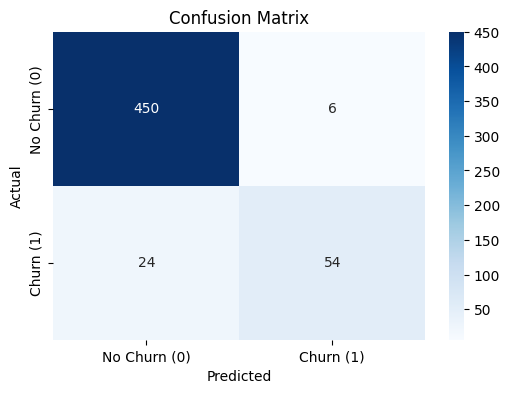

In [15]:
print("\nModel Performance")


# Accuracy

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:, {accuracy:.4f}")

# Precision

precision = precision_score(y_test, y_pred)
print(f"Precision:, {precision:.4f}")

# Recall

recall = recall_score(y_test, y_pred)
print(f"Recall:, {recall:.4f}")

# F1 score

f1 = f1_score(y_test, y_pred)
print(f"F1 Score:, {f1:.4f}")

# ROC-AUC

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC:, {roc_auc:.4f}")

# Confusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizing the Confusion Matrix

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Actual Churn and Predicted Churn

true_churn = np.sum(y_test)
predicted_churn = np.sum(y_pred)
correctly_predicted_churn = np.sum(np.logical_and(y_test == 1, y_pred == 1))

print("Actual Churn:", true_churn)
print("Predicted Churn:", predicted_churn)
print("Correctly Predicted Churn:", correctly_predicted_churn)

Actual Churn: 78
Predicted Churn: 60
Correctly Predicted Churn: 54


## 5. Model Saving and Loading

After successfully training and optimizing a machine learning model, it's crucial to save it to disk. This allows for several key benefits:

-   **Efficiency:** You don't need to retrain the model every time you want to use it. Training can be computationally intensive and time-consuming, especially for large datasets or complex models.
-   **Deployment:** Saved models can be easily loaded into production environments (e.g., a web application, an API service) to make real-time predictions on new, unseen data.
-   **Reproducibility:** Saving the exact model state (after tuning) ensures that the same model can be used consistently for future predictions or further analysis, aiding reproducibility.

Conversely, loading a saved model enables you to instantly reuse the trained model without re-running the entire training pipeline.

### 5.1. Saving the Trained Model
We use the `joblib` library (recommended for Scikit-learn and XGBoost models due to its efficiency with NumPy arrays) to save the `best_model` obtained from `GridSearchCV`.

In [17]:
# Save the Model

print("\n### Model Save ###")
# Model name and path
model_filename = 'xgboost_churn_model.joblib'

# Save best_model as joblib
joblib.dump(best_model, model_filename)
print(f" '{model_filename}' is successfully saved.")

# --- load the save model ---
print("\n### Load the save model and check ###")
loaded_model = joblib.load(model_filename)
print(f" '{model_filename}' is successfully loaded")

# Test
sample_prediction = loaded_model.predict(X_test.head(5))
print(f"\nPrediction with the loaded model: {sample_prediction}")

# Check
original_prediction = best_model.predict(X_test.head(5))
print(f"Prediction with the original model: {original_prediction}")

if (sample_prediction == original_prediction).all():
    print("Predictions between the original and loaded model are the same. Successfully loaded!")
else:
    print("Warnung: Predictions are different.")

print("="*50)


### Model Save ###
 'xgboost_churn_model.joblib' is successfully saved.

### Load the save model and check ###
 'xgboost_churn_model.joblib' is successfully loaded

Prediction with the loaded model: [0 0 0 0 0]
Prediction with the original model: [0 0 0 0 0]
Predictions between the original and loaded model are the same. Successfully loaded!
